# Predicting Hospital Readmission for Patients with Diabetes
### by Nishant Nayak
### May 9th, 2021

## Project summary
The objective of this project is to develop a model that will predict whether or not a patient will be readmitted within 30 days. The report is divided into six sections:
- Data exploration
- Feature extraction
- Creating Training / Validation / Test Data
- Model Selection
- Test Evaluation
- Conclusion

The best model, the SGD Logistic Regression classifer, has a 67% test accuracy on held-out data and an AUC score of 0.66.

## Data exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
hospital_df = pd.read_csv('diabetic_data.csv')
print('Total number samples: ', len(hospital_df))

Total number samples:  101766


In [3]:
hospital_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Each sample in our dataset has 49 features. The two main types of features are categorical (`race`, `gender`), and numerical (`time_in_hospital`). To understand the features better, I'll look at the unique values for each feature.

In [4]:
for column in list(hospital_df):
    unique_vals = hospital_df[column].unique()
    
    if len(unique_vals) < 20:
        print(column + ':')
        print(unique_vals)
    else:
        print(column + ':')
        print(str(len(unique_vals)) + ' unique values')

encounter_id:
101766 unique values
patient_nbr:
71518 unique values
race:
['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
gender:
['Female' 'Male' 'Unknown/Invalid']
age:
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
weight:
['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
admission_type_id:
[6 1 2 3 4 5 8 7]
discharge_disposition_id:
26 unique values
admission_source_id:
[ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]
time_in_hospital:
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
payer_code:
['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
medical_specialty:
73 unique values
num_lab_procedures:
118 unique values
num_procedures:
[0 5 1 6 2 3 4]
num_medications:
75 unique values
number_outpatient:
39 unique values
number_emergency:
33 unique values
number_inpatient:
21 unique values
diag_1:
717 unique values
diag_2:
7

Using the information from IDs_mapping.csv, we notice that IDs 11, 13, 14, 19, 20, and 21 in the `discharge_disposition_id` variable relate to death or hospice. The samples with these discharge_disposition_ids are not related to our predictive task, so we will remove these samples from our dataset.

In [5]:
hospital_df = hospital_df.loc[~hospital_df.discharge_disposition_id.isin([11, 13, 14, 19, 20, 21])]
print('Total number samples: ', len(hospital_df))

Total number samples:  99343


We define a output label for our classification task. If the patient is readmitted within 30 days, the output  label is 1, otherwise the output label is 0.

In [8]:
hospital_df['output_label'] = (hospital_df['readmitted'] == '<30').astype('int')
hospital_df[['readmitted', 'output_label']].head()

,readmitted,output_label
0,NO,0
1,>30,0
2,NO,0
3,NO,0
4,NO,0


In [9]:
print('Prevalance of readmitted patients:', 
      sum(hospital_df['output_label'].values) / len(hospital_df['output_label'].values))

Prevalance of readmitted patients: 0.11388824577474005


### Takeaways
- In this dataset age and weight are categorical variables (ranges) and not numerical variables (specific values)
- We will not use the `examide` or `citoglipton` feature because it only has a single value, 'No'
- Most of the features have between 2-20 unique values. A few of the features such as `medical_speciality` and `num_lab_procedures` have more than 20 unique values
- 11.38% of the sample population is readmitted. This represents an imbalanced classification problem.

## Feature Extraction

In [19]:
# replace ? with nan
hospital_df = hospital_df.replace('?', np.nan)

### Numerical features
These features have specific integer values and do not need to be modified. The columns that have numerical features are shown below.

In [20]:
numerical_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                  'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

We want to ensure there are no missing values in the numerical features.

In [21]:
hospital_df[numerical_cols].isnull().sum()

time_in_hospital      0
num_lab_procedures    0
num_procedures        0
num_medications       0
number_outpatient     0
number_emergency      0
number_inpatient      0
number_diagnoses      0
dtype: int64

The `age` and `weight` columns are categorical ranges, but we want to convert them to numerical data. We use a dictionary to map the age ranges to specific integer values and since most samples do not have a weight measurement, we create a `has_weight` column.

In [22]:
age_id = {'[0-10)': 0, 
          '[10-20)': 10, 
          '[20-30)': 20, 
          '[30-40)': 30, 
          '[40-50)': 40, 
          '[50-60)': 50,
          '[60-70)': 60, 
          '[70-80)': 70, 
          '[80-90)': 80, 
          '[90-100)': 90}
hospital_df['age_group'] = hospital_df.age.replace(age_id)

hospital_df['has_weight'] = hospital_df.weight.notnull().astype('int')
numerical_cols.append('age_group')
numerical_cols.append('has_weight')

### Categorical features
Categorical features are qualitative, non-numeric data such as gender or race. We use one-hot encoding to turn the non-numeric data into numeric variables.

In [23]:
medicines = list(hospital_df.columns)[21:46]
medicines.remove('examide')
medicines.remove('citoglipton')
categorical_cols = ['race', 'gender', 'payer_code', 'medical_specialty'] + medicines + ['change', 'diabetesMed'] 

We want to ensure there are no missing values in the numerical features.

In [24]:
hospital_df[categorical_cols].isnull().sum()

race                         2234
gender                          0
payer_code                  39398
medical_specialty           48616
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
insulin                         0
glyburide-metformin             0
glipizide-metformin             0
glimepiride-pioglitazone        0
metformin-rosiglitazone         0
change                          0
diabetesMed                     0
dtype: int64

`race`, `payer_code`, and `medical_specialty` columns all have missing data. We replace these unknown with an UNK token.

In [25]:
hospital_df['race'] = hospital_df['race'].fillna('UNK')
hospital_df['payer_code'] = hospital_df['payer_code'].fillna('UNK')
hospital_df['medical_specialty'] = hospital_df['medical_specialty'].fillna('UNK')

Since we want to change the categorical features to one-hot encoding, we want to limit sparsity. The `race` and `payer_code` columns have only a few unique values, but the `medical_speciality` column has 73 unique values. 

In [26]:
hospital_df.groupby('medical_specialty').size().sort_values(ascending = False)[:10]

medical_specialty
UNK                           48616
InternalMedicine              14237
Emergency/Trauma               7419
Family/GeneralPractice         7252
Cardiology                     5279
Surgery-General                3059
Nephrology                     1539
Orthopedics                    1392
Orthopedics-Reconstructive     1230
Radiologist                    1121
dtype: int64

Most of the samples are categorized as the UNK token and the counts drop off quickly. We want to reduce the number of unique values in the `medical_speciality` column so we only keep the top 10 most common categories, and add a 'Other' value for the remaining categories.

In [27]:
top_10 = list(hospital_df.groupby('medical_specialty').size().sort_values(ascending = False)[:10].index)

hospital_df['med_spec'] = hospital_df['medical_specialty']

# replace all specialties not in the top 10 with the 'Other' category
hospital_df.loc[~hospital_df.med_spec.isin(top_10), 'med_spec'] = 'Other'

In [28]:
hospital_df.groupby('med_spec').size().sort_values(ascending = False)

med_spec
UNK                           48616
InternalMedicine              14237
Other                          8199
Emergency/Trauma               7419
Family/GeneralPractice         7252
Cardiology                     5279
Surgery-General                3059
Nephrology                     1539
Orthopedics                    1392
Orthopedics-Reconstructive     1230
Radiologist                    1121
dtype: int64

Use the get_dummies function to create the one-hot encoding representation of our categorical features.

In [29]:
# Convert categorical numbers to strings for get_dummies function
categorical_num_cols = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
hospital_df[categorical_num_cols] = hospital_df[categorical_num_cols].astype('str')

categorical_cols.remove('medical_specialty')
df_encoded = pd.get_dummies(hospital_df[categorical_cols + categorical_num_cols + ['med_spec']], drop_first = True)

In [30]:
df_encoded.head()

,number_diagnoses,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK,gender_Male,gender_Unknown/Invalid,payer_code_CH,payer_code_CM,...,med_spec_Emergency/Trauma,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,9,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,7,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [31]:
# add one-hot encoding data to original data
hospital_df = pd.concat([hospital_df, df_encoded], axis = 1)
all_categorical_cols = list(df_encoded.columns)

We create a new dataframe that only has our desired features and the output label

In [32]:
feature_cols = numerical_cols + all_categorical_cols
hospital_data = hospital_df[feature_cols + ['output_label']]

In [33]:
hospital_data.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,number_diagnoses,age_group,...,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK,output_label
0,1,41,0,1,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
1,3,59,0,18,0,0,0,9,9,10,...,0,0,0,0,0,0,0,0,1,0
2,2,11,5,13,2,0,1,6,6,20,...,0,0,0,0,0,0,0,0,1,0
3,2,44,1,16,0,0,0,7,7,30,...,0,0,0,0,0,0,0,0,1,0
4,1,51,0,8,0,0,0,5,5,40,...,0,0,0,0,0,0,0,0,1,0


## Creating Training / Validation / Test Sets

The data will be split into 70% training, 15% validation, and 15% test.

In [34]:
# Shuffle the samples
hospital_data = hospital_data.sample(n = len(hospital_data), random_state = 5)
hospital_data = hospital_data.reset_index(drop = True)

# Save 30% for val / test
hospital_val_test = hospital_data.sample(frac = 0.3, random_state = 5)
test_data = hospital_val_test.sample(frac = 0.5, random_state = 5)
val_data = hospital_val_test.drop(test_data.index)

# Use remaining data as training data
training_data = hospital_data.drop(hospital_val_test.index)

# Sanity check
print('Training data prevalence (n = ' + str(len(training_data)) + '): ' + 
      str(sum(training_data['output_label'].values) / len(training_data['output_label'].values)))

print('Validation data prevalence (n = ' + str(len(val_data)) + '): ' + 
      str(sum(val_data['output_label'].values) / len(val_data['output_label'].values)))

print('Test data prevalence (n = ' + str(len(test_data)) + '): ' + 
      str(sum(test_data['output_label'].values) / len(test_data['output_label'].values)))

Training data prevalence (n = 69540): 0.11392004601668104
Validation data prevalence (n = 14901): 0.11408630293268908
Test data prevalence (n = 14902): 0.11354180646893035


Since the data is unbalanced, we will use a sub-sampling approach to create a balanced training data set with 50% readmissions (positive) and 50% non-readmissions (negative).

In [35]:
# Split training data into positive and negative
pos_rows = training_data.output_label == 1
train_pos = training_data.loc[pos_rows]
train_neg = training_data.loc[~pos_rows]

# Merging data in balanced way and shuffle
training_data = pd.concat([train_pos, train_neg.sample(len(train_pos), random_state = 5)], axis = 0)
training_data = training_data.sample(n = len(training_data), random_state = 5).reset_index(drop = True)

print('Training data prevalence (n = ' + str(len(training_data)) + '): ' + 
      str(sum(training_data['output_label'].values) / len(training_data['output_label'].values)))

Training data prevalence (n = 15844): 0.5


In [36]:
training_data.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,number_diagnoses,age_group,...,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK,output_label
0,3,37,0,12,0,0,2,6,6,80,...,1,0,0,0,0,0,0,0,0,0
1,9,80,0,16,0,0,0,6,6,80,...,0,1,0,0,0,0,0,0,0,1
2,5,55,2,12,0,0,1,6,6,70,...,1,0,0,0,0,0,0,0,0,1
3,3,43,0,15,2,0,1,8,8,60,...,0,0,1,0,0,0,0,0,0,1
4,1,25,1,14,0,0,0,5,5,40,...,0,0,0,0,0,1,0,0,0,0


Machine learning packages use input matrix X and output vector y, so we manipulate our data to fit this format. We use sci-kit learn's Standard Scaler function to scale our data to unit variance.

In [37]:
X_all = hospital_data[feature_cols].values
X_train = training_data[feature_cols].values
X_val = val_data[feature_cols].values

y_train = training_data['output_label'].values
y_val = val_data['output_label'].values

print('Training data shapes:', X_train.shape, y_train.shape)
print('Validation data shapes:', X_val.shape, y_val.shape)

Training data shapes: (15844, 149) (15844,)
Validation data shapes: (14901, 149) (14901,)


In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_all)

X_train_tf = scaler.transform(X_train)
X_val_tf = scaler.transform(X_val)

With out transformed, normalized training features and labels, we can proceed to selecting a model for classification.

## Model Selection

In this section, I will compare the K-nearest neighbors model, logistic regression model, and the decision tree classifier. Our metrics for comparing the models will be the AUC score, accuracy score, precision score, and recall score. It's important to note that guessing 'not readmitted' for every sample would result in a 89% accuracy rate, yet the recall would be 0%, since we would never predict a readmission. Guessing randomly would result in a 50% accuracy rate.

In [39]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

def print_report(y_actual, y_pred, threshold = 0.5):
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > threshold))
    recall = recall_score(y_actual, (y_pred > threshold))
    precision = precision_score(y_actual, (y_pred > threshold))
    print('AUC: ', auc)
    print('accuracy: ', accuracy)
    print('recall: ', recall)
    print('precision: ', precision)
    return auc, accuracy, recall, precision

### K-nearest neighbors (KNN)

In [40]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(n_neighbors=100)

In [41]:
y_train_pred = knn.predict_proba(X_train_tf)[:, 1]
y_val_pred = knn.predict_proba(X_val_tf)[:, 1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_acc, knn_train_recall, knn_train_prec = print_report(y_train, y_train_pred)
print()
print('Validation:')
knn_val_auc, knn_val_acc, knn_val_recall, knn_val_prec = print_report(y_val, y_val_pred)

KNN
Training:
AUC:  0.6471683074327126
accuracy:  0.6006690229739965
recall:  0.5059328452411007
precision:  0.6242018377199813

Validation:
AUC:  0.633711283013319
accuracy:  0.6600899268505469
recall:  0.5141176470588236
precision:  0.17093682769411306


### SGD (stochastic gradient descent) Logistic Regression

In [42]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier(loss = 'log', alpha = 0.1, random_state = 5)

sgdc.fit(X_train_tf, y_train)

SGDClassifier(alpha=0.1, loss='log', random_state=5)

In [43]:
y_train_pred = sgdc.predict_proba(X_train_tf)[:, 1]
y_val_pred = sgdc.predict_proba(X_val_tf)[:, 1]

print('SGD Logistic Regression')
print('Training:')
sgd_train_auc, sgd_train_acc, sgd_train_recall, sgd_train_prec = print_report(y_train, y_train_pred)
print()
print('Validation:')
sgd_val_auc, sgd_val_acc, sgd_val_recall, sgd_val_prec = print_report(y_val, y_val_pred)

SGD Logistic Regression
Training:
AUC:  0.6663677304106352
accuracy:  0.6197298661954052
recall:  0.5568038374147942
precision:  0.6369675090252708

Validation:
AUC:  0.6792550475231378
accuracy:  0.6630427488088048
recall:  0.5741176470588235
precision:  0.18509387445476957


### Decision Tree Classifier


In [44]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state = 5)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(max_depth=10, random_state=5)

In [45]:
y_train_pred = tree.predict_proba(X_train_tf)[:, 1]
y_val_pred = tree.predict_proba(X_val_tf)[:, 1]

print('Decision Tree Classifier')
print('Training:')
tree_train_auc, tree_train_acc, tree_train_recall, tree_train_prec = print_report(y_train, y_train_pred)
print()
print('Validation:')
tree_val_auc, tree_val_acc, tree_val_recall, tree_val_prec = print_report(y_val, y_val_pred)

Decision Tree Classifier
Training:
AUC:  0.7377043728740985
accuracy:  0.6665614743751578
recall:  0.6055289068417067
precision:  0.6897196261682244

Validation:
AUC:  0.639067027007758
accuracy:  0.6488826253271592
recall:  0.5547058823529412
precision:  0.17404946474713917


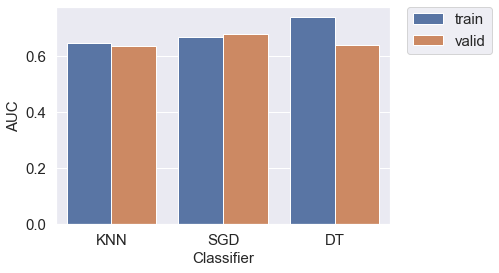

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

model_results = pd.DataFrame({'classifier':['KNN','KNN','SGD','SGD','DT','DT'],
                           'data_set':['train','valid'] * 3,
                           'auc':[knn_train_auc, knn_val_auc, sgd_train_auc, sgd_val_auc, 
                                  tree_train_auc, tree_val_auc]})

ax = sns.barplot(x= "classifier", y= "auc", hue= "data_set", data = model_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

### Takeaways
- The Decision Tree Classifier performed the best on the training data, but the performance did not carry over to the validation data.
- The K-nearest neighbor classifier was the worst performing model of the three models
- The SGD Logistic Regression classifier performed better than the KNN model and was more consistent that the Decision Tree Classifier, so this classifier will be used for classifying our test data.

## Test Evaluation

After comparing three different classifiers, our result show that the SGD Logistic Regression classifier performed better and more robustly than the other two models. We will use this model in our test evaluation.

In [47]:
X_test = test_data[feature_cols].values
y_test = test_data['output_label'].values
X_test_tf = scaler.transform(X_test)

In [48]:
sgdc_final = SGDClassifier(loss = 'log', alpha = 0.1, random_state = 5)
sgdc_final.fit(X_train_tf, y_train)

y_train_pred = sgdc_final.predict_proba(X_train_tf)[:,1]
y_val_pred = sgdc_final.predict_proba(X_val_tf)[:,1]
y_test_pred = sgdc_final.predict_proba(X_test_tf)[:,1]

print('SGD Logistic Regression')
print('Training:')
sgd_train_auc, sgd_train_acc, sgd_train_recall, sgd_train_prec = print_report(y_train, y_train_pred)
print()
print('Validation:')
sgd_val_auc, sgd_val_acc, sgd_val_recall, sgd_val_prec = print_report(y_val, y_val_pred)
print()
print('Test:')
sgd_test_auc, sgd_test_acc, sgd_test_recall, sgd_test_prec = print_report(y_test, y_test_pred)

SGD Logistic Regression
Training:
AUC:  0.6663677304106352
accuracy:  0.6197298661954052
recall:  0.5568038374147942
precision:  0.6369675090252708

Validation:
AUC:  0.6792550475231378
accuracy:  0.6630427488088048
recall:  0.5741176470588235
precision:  0.18509387445476957

Test:
AUC:  0.6538727019254345
accuracy:  0.6597101060260367
recall:  0.5455082742316785
precision:  0.17665071770334928


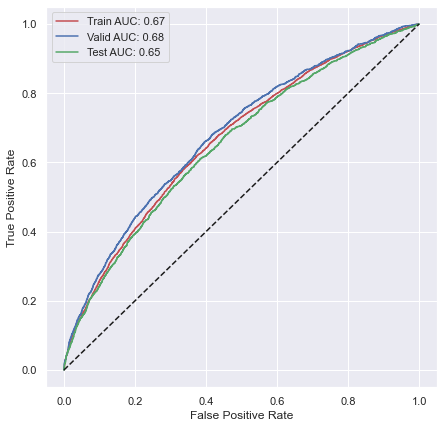

In [50]:
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
auc_train = roc_auc_score(y_train, y_train_pred)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_val, y_val_pred)
auc_valid = roc_auc_score(y_val, y_val_pred)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
auc_test = roc_auc_score(y_test, y_test_pred)

plt.figure(figsize=(7,7))
plt.plot(fpr_train, tpr_train, 'r', label = ('Train AUC: ' + str(round(auc_train, 2))))
plt.plot(fpr_valid, tpr_valid, 'b',label = ('Valid AUC: ' + str(round(auc_valid, 2))))
plt.plot(fpr_test, tpr_test, 'g',label =('Test AUC: ' +  str(round(auc_test, 2))))
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

## Conclusion

The objective of this modeling task was to find a model that could predict the probability that a patient would be readmitted into the hospital after 30 days. Once again, it is important to note that guessing 'not readmitted' for every sample would result in a 89% accuracy rate, yet the recall would be 0%, since we would never predict a readmission. Guessing randomly would result in a 50% accuracy rate. Our best model, the SGD Logistic Regression classifer, had a 67% test accuracy on held-out data and AUC score of 0.66. There is room for improvement by performing more detailed data research, tuning the hyperparameters of the models, and using new models such as multi-layer perceptron binary classifiers.